In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy import stats

In [3]:
# Load data
df = pd.read_csv('diabetes.csv')

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [23]:
df.isnull()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
763,False,False,False,False,False,False,False,False,False
764,False,False,False,False,False,False,False,False,False
765,False,False,False,False,False,False,False,False,False
766,False,False,False,False,False,False,False,False,False


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    float64
 8   Outcome                   768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


In [29]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.837240,121.656250,72.358073,28.866536,124.691081,32.393359,0.458914,33.199870,0.348958
std,3.344157,30.438286,11.697097,7.442353,7.913595,6.667471,0.285596,11.628404,0.476951
min,0.000000,44.000000,40.000000,14.500000,112.875000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,13.500000,199.000000,104.000000,42.500000,135.875000,50.250000,1.200000,66.500000,1.000000


In [5]:
# ====================================================================
# 1. Handle Missing Values (Zeros)
# ====================================================================
# Replace 0s with NaN in biological features
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_cols] = df[zero_cols].replace(0, np.nan)

In [9]:
# Impute missing values with median
imputer = SimpleImputer(strategy='median')
df[zero_cols] = imputer.fit_transform(df[zero_cols])

In [11]:
# ====================================================================
# 2. Handle Outliers
# ====================================================================
def cap_outliers(df, cols, factor=1.5):
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - factor*iqr
        upper_bound = q3 + factor*iqr
        df[col] = np.where(df[col] < lower_bound, lower_bound,
                         np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df

outlier_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df = cap_outliers(df, outlier_cols)

In [13]:
# ====================================================================
# 3. Handle Class Imbalance
# ====================================================================
X = df.drop('Outcome', axis=1)
y = df['Outcome']


In [15]:
# Check imbalance
print("Class Distribution Before Balancing:")
print(y.value_counts())

Class Distribution Before Balancing:
Outcome
0    500
1    268
Name: count, dtype: int64


In [17]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [19]:
print("\nClass Distribution After Balancing:")
print(pd.Series(y_res).value_counts())


Class Distribution After Balancing:
Outcome
1    500
0    500
Name: count, dtype: int64


In [31]:
# ====================================================================
# 4. Feature Scaling
# ====================================================================
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_res)
df_processed = pd.DataFrame(scaled_features, columns=X.columns)
df_processed['Outcome'] = y_res.reset_index(drop=True)

In [33]:
# ====================================================================
# 5. Additional Cleaning
# ====================================================================
# Handle impossible values
df_processed['Pregnancies'] = df_processed['Pregnancies'].apply(lambda x: x if x >= 0 else 0)
df_processed['Age'] = df_processed['Age'].apply(lambda x: x if x <= 100 else 100)

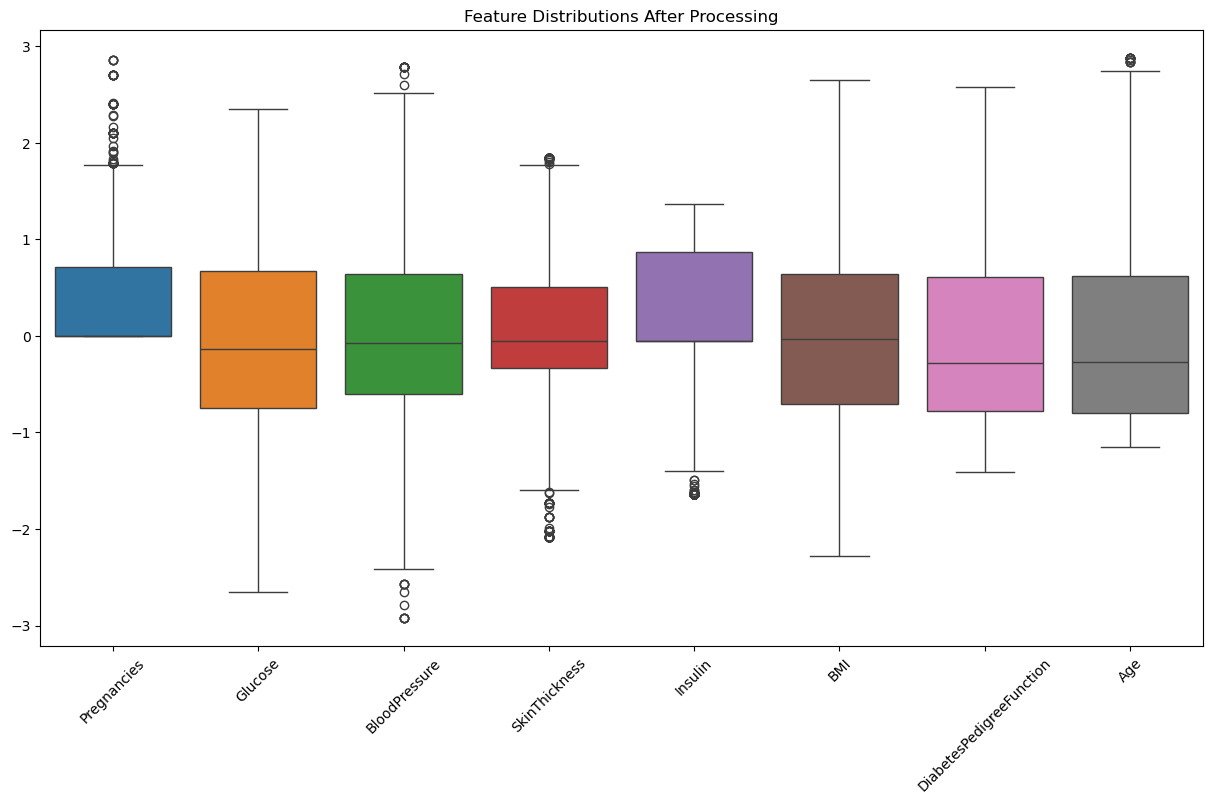

In [35]:
# ====================================================================
# Visualization & Final Checks
# ====================================================================
# Boxplot after outlier treatment
plt.figure(figsize=(15,8))
sns.boxplot(data=df_processed.drop('Outcome', axis=1))
plt.title('Feature Distributions After Processing')
plt.xticks(rotation=45)
plt.show()

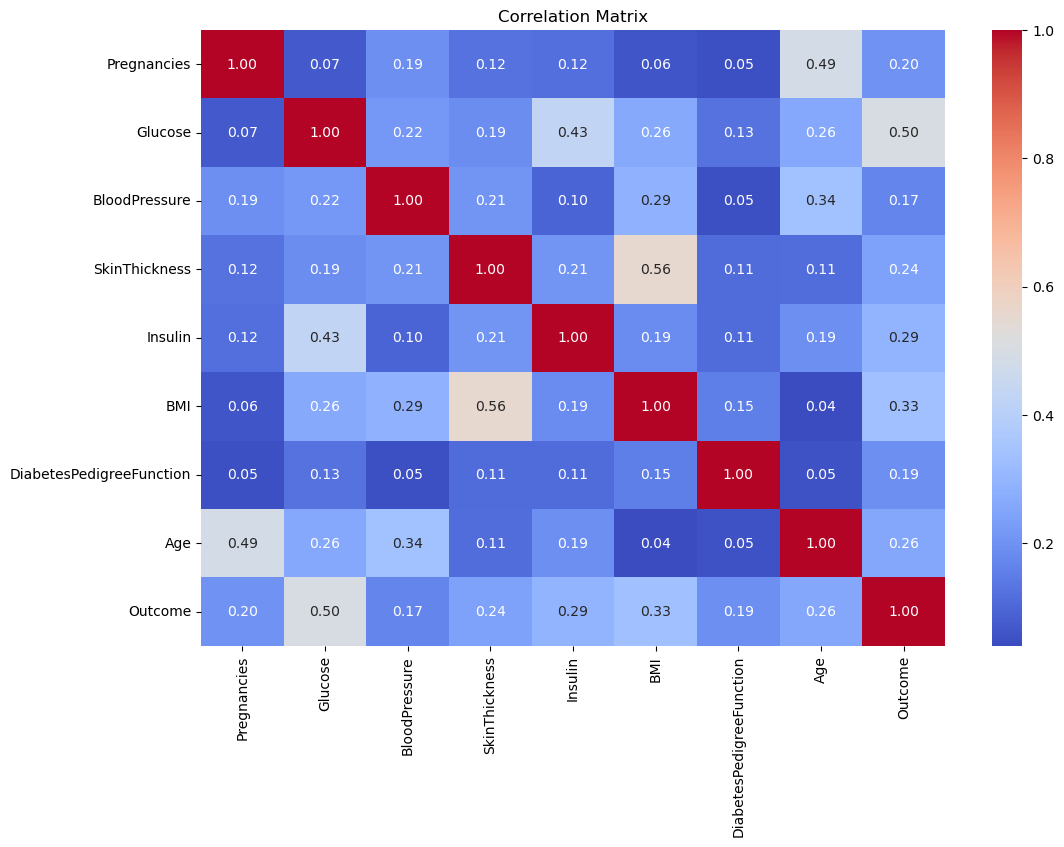

In [37]:
# Correlation matrix heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_processed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [39]:
# Final dataset preview
print("\nProcessed Dataset Preview:")
display(df_processed.head())


Processed Dataset Preview:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.584370,0.704327,-0.071147,0.788778,-0.051567,0.087057,0.542715,1.415183,1
1,0.000000,-1.328176,-0.605891,-0.052656,-0.051567,-0.990698,-0.439625,-0.268354,0
2,1.189537,1.833495,-0.784139,-0.052656,-0.051567,-1.498783,0.702879,-0.179747,1
3,0.000000,-1.199128,-0.605891,-0.894090,-1.637924,-0.759750,-1.094519,-1.154426,0
4,0.000000,0.349445,-2.923117,0.788778,1.371249,1.549725,2.582139,-0.091140,1


In [41]:
# Save cleaned data
df_processed.to_csv('diabetes_processed.csv', index=False)

## part 2 for modelling and prediction 

In [4]:
pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/124.9 MB 837.5 kB/s eta 0:02:29
   ---------------------------------------- 1.0/124.9 MB 1.4 MB/s eta 0:01:32
    --------------------------------------- 2.6/124.9 MB 2.8 MB/s eta 0:00:43
   - -------------------------------------- 3.4/124.9 MB 3.0 MB/s eta 0:00:40
   - -------------------------------------- 4.5/124.9 MB 3.4 MB/s eta 0:00:36
   - -------------------------------------- 4.7/124.9 MB 3.5 MB/s eta 0:00:35
   -- ------------------------------------- 7.9/124.9 MB 4.5 MB/s eta 0:00:26
   --- -------------------

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, RocCurveDisplay)
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
import joblib

In [8]:
# Load processed dataset
df = pd.read_csv('diabetes_processed.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [34]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.584370,0.704327,-0.071147,0.788778,-0.051567,0.087057,0.542715,1.415183,1
1,0.000000,-1.328176,-0.605891,-0.052656,-0.051567,-0.990698,-0.439625,-0.268354,0
2,1.189537,1.833495,-0.784139,-0.052656,-0.051567,-1.498783,0.702879,-0.179747,1
3,0.000000,-1.199128,-0.605891,-0.894090,-1.637924,-0.759750,-1.094519,-1.154426,0
4,0.000000,0.349445,-2.923117,0.788778,1.371249,1.549725,2.582139,-0.091140,1


In [42]:
df.shape

(1000, 9)

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
# Define XGBoost classifier with balanced class weighting
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [14]:
# Hyperparameter grid for optimization
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 4, 5],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__subsample': [0.8, 0.9],
    'xgbclassifier__colsample_bytree': [0.7, 0.8],
    'xgbclassifier__gamma': [0, 0.1, 0.2],
    'xgbclassifier__scale_pos_weight': [1, 1.5]  # Handle any residual imbalance
}

In [16]:
# Create pipeline
pipeline = Pipeline([
    ('xgbclassifier', xgb)
])

In [18]:
# Configure grid search with stratified K-fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',  # Optimize for balance of precision/recall
    cv=kfold,
    n_jobs=-1,
    verbose=1
)


In [20]:
# Train model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


G:\anaconda packages\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
G:\anaconda packages\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      gamm...
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__colsample_bytree': [0.7, 0.8],
                         'xgbclassifier__gamma': [0, 0.1, 0.2],
                         'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 4, 5],
                         'xgbclassifier__n_estimators': [100, 200, 300],
                         'xgbclassifier__scale_pos_weight': [1, 1.5],
                         'xgbclassifier__subsample': [0.8, 0.9]},
             scoring='f1', verbose=1)

In [26]:
# Get best model
best_model = grid_search.best_estimator_

In [28]:
# Generate predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [30]:
# Evaluation metrics
print("=== Best Parameters ===")
print(grid_search.best_params_)
print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

=== Best Parameters ===
{'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__gamma': 0.2, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__scale_pos_weight': 1, 'xgbclassifier__subsample': 0.8}

=== Evaluation Metrics ===
Accuracy: 0.7950
Precision: 0.7864
Recall: 0.8100
F1 Score: 0.7980
ROC AUC: 0.8912


In [32]:
# Classification report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       100
           1       0.79      0.81      0.80       100

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



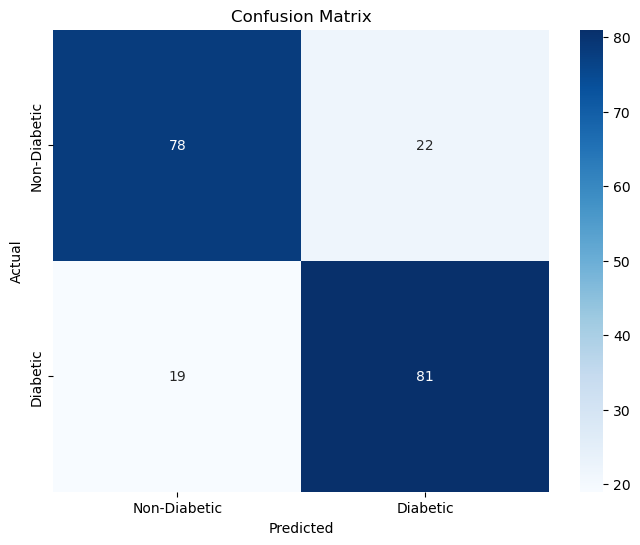

In [44]:
# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

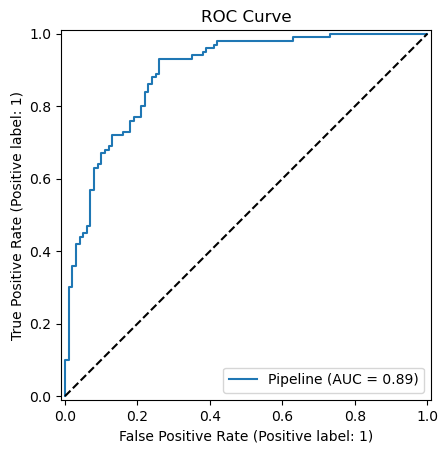

In [46]:
# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()


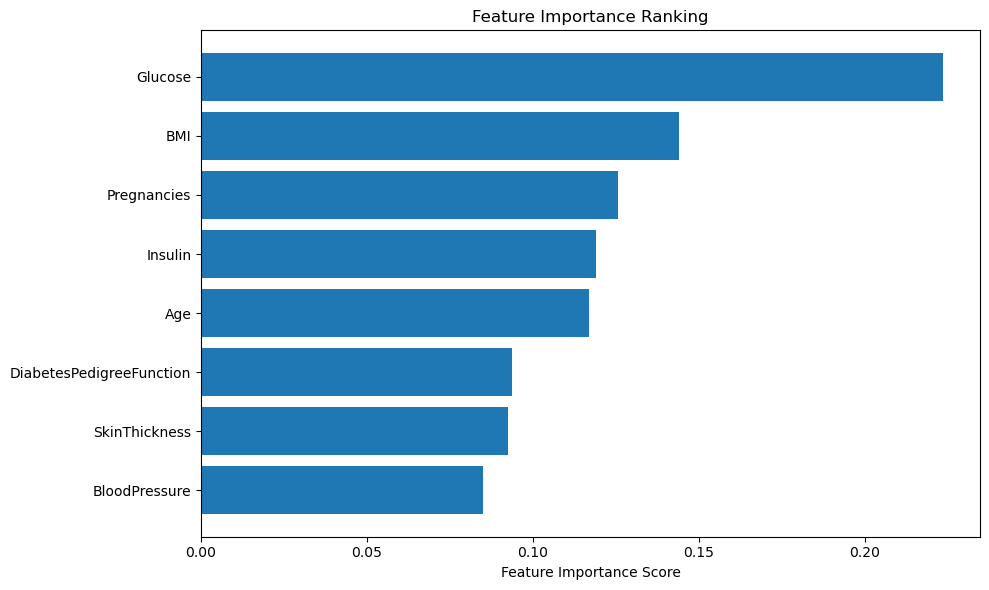

In [48]:
# Feature importance
feature_importance = best_model.named_steps['xgbclassifier'].feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Feature Importance Score')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [50]:
# Save model
joblib.dump(best_model, 'diabetes_xgboost_model.pkl')

['diabetes_xgboost_model.pkl']

In [52]:
# Sample prediction
sample_data = X_test.iloc[0:1]
prediction = best_model.predict(sample_data)
prediction_proba = best_model.predict_proba(sample_data)

print("\n=== Sample Prediction ===")
print(f"Features:\n{sample_data}")
print(f"\nPrediction: {'Diabetic' if prediction[0] == 1 else 'Non-Diabetic'}")
print(f"Probability: {prediction_proba[0][1]:.2%} chance of diabetes")


=== Sample Prediction ===
Features:
     Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
907     2.284368 -1.097724      -0.953882      -1.989092  1.303357 -0.804408   

     DiabetesPedigreeFunction       Age  
907                  1.476996  0.828576  

Prediction: Diabetic
Probability: 93.60% chance of diabetes
